In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
a50= pd.read_csv('/Users/nanyueming/Documents/研究生/泰创量化/1012回报/50.csv')

In [3]:
a50.Date= pd.to_datetime(a50.Date)

In [4]:
IH= pd.read_csv('/Users/nanyueming/Documents/研究生/泰创量化/1012回报/IH.csv')

In [5]:
IH.Date= pd.to_datetime(IH.Date)

In [6]:
import statsmodels
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [7]:
def granger(df):
    
    ts.grangercausalitytests(df, maxlag= 2)

In [8]:
def VAR_test(df, lag):
    
    var_mod= VAR(df)
    var_fit= var_mod.fit(lag)
    print(var_fit.summary())
    
    #残差序列
    resid= var_fit.resid        
    resid.plot(subplots= True, figsize= (10, 10), linewidth= 1.7)
    
    #残差序列平稳性检验 
    var_fit.plot_acorr()
    resid_test= ts.coint(resid[resid.columns[0]], resid[resid.columns[1]])[1]
    if resid_test < 0.1:
        print('p_value: ', resid_test)
        print('残差序列平稳')
    else: print('残差序列非平稳')
    
    #脉冲响应图                            
    irf = var_fit.irf(10)
    irf.plot(orth=False)

    2020年上半年数据

In [9]:
a502020= a50[a50['Date']>= '2020-1-1']
a502020= a502020[a502020['Date']<= '2020-7-1']
a502020.dropna(inplace= True)
IH2020= IH[IH['Date']>= '2020-1-1']
IH2020= IH2020[IH2020['Date']<= '2020-7-1']
df2= pd.merge(a502020, IH2020, on=['Date','Time'], how= 'left')
df2= df2.loc[:,['Date','Time','Close_x','Close_y']]
df2.rename(columns = {'Date':'date', 'Time':'time', 
                     'Close_x':'a50_close', 'Close_y':'future_close'} , inplace = True)
df2= df2[df2['time']!='9:25 AM']
df2.dropna(inplace= True)

<AxesSubplot:>

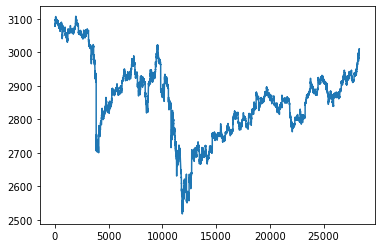

In [10]:
df2['a50_close'].plot()

In [11]:
df3= df2.loc[:,['a50_close','future_close']].pct_change(1)
df3.dropna(inplace= True)

In [12]:
df3.skew()

a50_close      -28.644697
future_close   -12.277537
dtype: float64

In [13]:
df3.kurt()

a50_close       2502.744989
future_close    1019.744158
dtype: float64

<AxesSubplot:xlabel='future_close', ylabel='Density'>

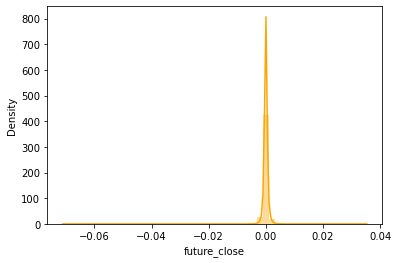

In [14]:
sns.distplot(df3['future_close'],color= 'orange')

In [15]:
granger(df3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=461.5495, p=0.0000  , df_denom=28236, df_num=1
ssr based chi2 test:   chi2=461.5985, p=0.0000  , df=1
likelihood ratio test: chi2=457.8665, p=0.0000  , df=1
parameter F test:         F=461.5495, p=0.0000  , df_denom=28236, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=267.7893, p=0.0000  , df_denom=28233, df_num=2
ssr based chi2 test:   chi2=535.6734, p=0.0000  , df=2
likelihood ratio test: chi2=530.6559, p=0.0000  , df=2
parameter F test:         F=267.7893, p=0.0000  , df_denom=28233, df_num=2


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 13, Oct, 2021
Time:                     21:41:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -29.1469
Nobs:                     28238.0    HQIC:                  -29.1489
Log likelihood:           331440.    FPE:                2.18973e-13
AIC:                     -29.1498    Det(Omega_mle):     2.18896e-13
--------------------------------------------------------------------
Results for equation a50_close
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.000000         0.000005           -0.078           0.938
L1.a50_close           -0.182756         0.011262          -16.227           0.000
L1.future_close         0.214773         0.00934

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


p_value:  0.0
残差序列平稳


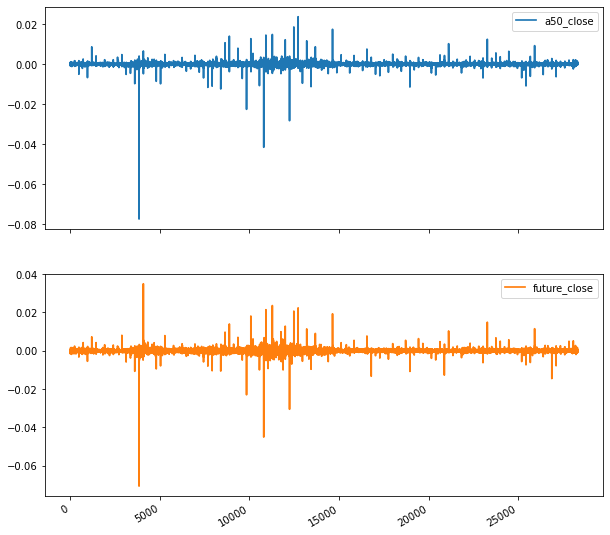

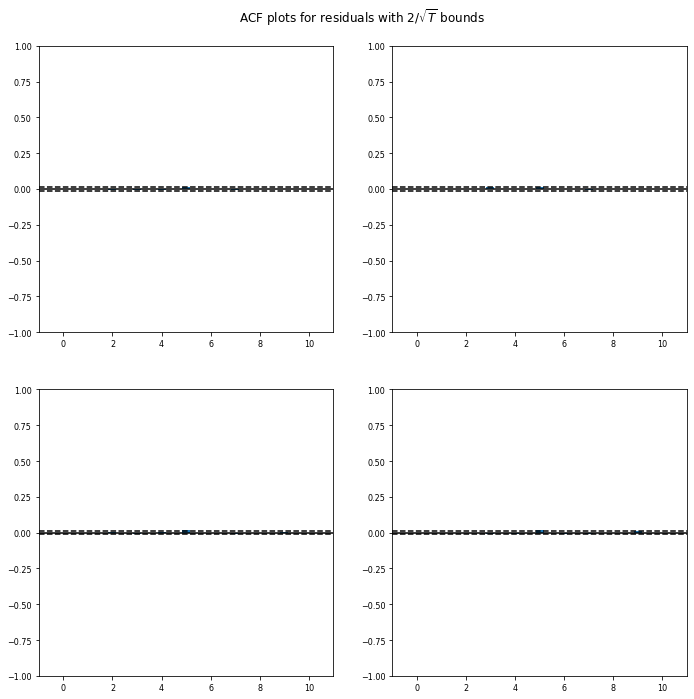

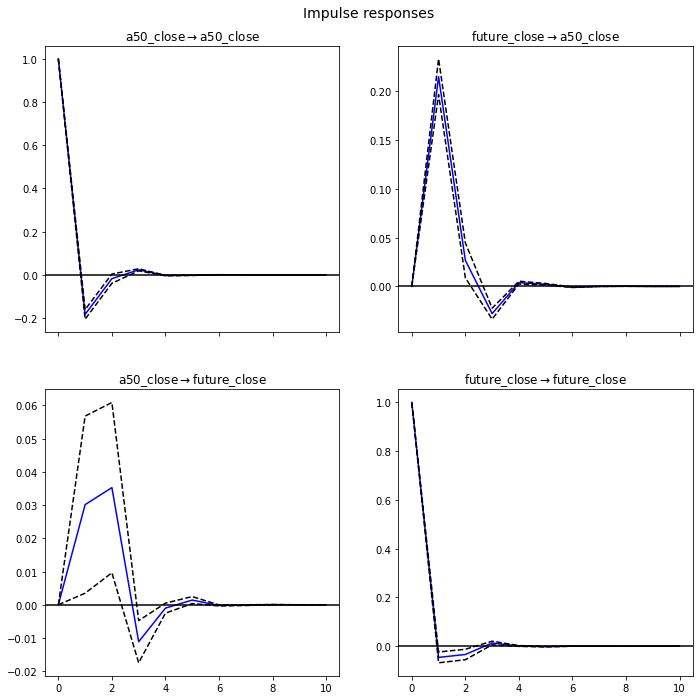

In [16]:
VAR_test(df3,2)

In [17]:
df2['basis']= (df2['a50_close']- df2['future_close'])/df2['a50_close']

In [18]:
df2['basis'].describe()

count    28241.000000
mean         0.004188
std          0.004515
min         -0.007123
25%          0.000597
50%          0.003537
75%          0.007193
max          0.028783
Name: basis, dtype: float64

In [19]:
df2['basis'].skew()

0.5604351639398725

In [20]:
df2['basis'].kurt()

-0.34472812607008496

<AxesSubplot:xlabel='basis', ylabel='Density'>

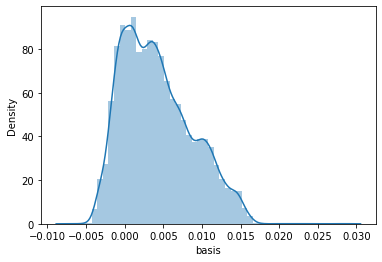

In [21]:
sns.distplot(df2['basis'])

    平均每分钟基差率在日内的分布情况：

In [22]:
df4= pd.DataFrame(np.abs(df2['basis']).groupby(df2['time']).mean())

<AxesSubplot:xlabel='time'>

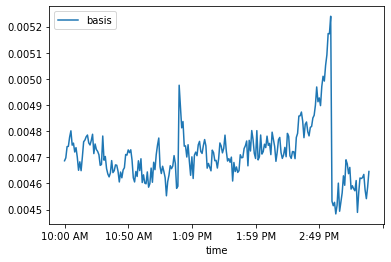

In [23]:
df4.plot()

    回测

In [24]:
df2["datetime"] =df2["date"].map(str) +"-"+ df2["time"].map(str)
df2.set_index('datetime', inplace= True)

In [25]:
df2['future_position']= 0 #期货仓位
df2['a50_position']= 0    #指数仓位
df2['open_position']= 0   #开仓
df2['close_position']= 0  #平仓
p1=0                      #是否持仓

for i in range(len(df2)-1):
    if p1==0:
        if df2['basis'][i] >= df2['basis'].quantile(0.65):
            #开仓
            df2['future_position'][i+1]= 1
            df2['a50_position'][i+1]= -1
            df2['open_position'][i+1]= 1
            p1=-1
        else:
            #不开仓
            p1=0
            
    else :
        if df2['basis'][i] <= df2['basis'].quantile(0.55):
            #平仓
            df2['future_position'][i+1]= -1
            df2['a50_position'][i+1]= 1
            df2['close_position'][i+1]= 1
            p1=0
        else:
            #不开仓
            p1=p1
            
    

<AxesSubplot:xlabel='time'>

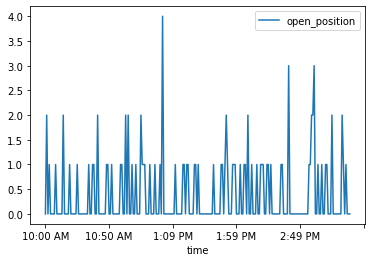

In [26]:
pd.DataFrame(df2['open_position'].groupby(df2['time']).sum()).plot()

In [27]:
df2['open_position'].sum()

91

In [28]:
df2['value']= 0.0
df2['money']= 100.00

In [29]:
for i in range(len(df2)-1):
    df2['future_position'][i+1]= df2['future_position'][i+1]+df2['future_position'][i]
    df2['a50_position'][i+1]= df2['a50_position'][i+1]+df2['a50_position'][i]

In [30]:
for i in range(len(df2)-1):
    df2['value'][i+1]= (df2['future_close'][i+1]-df2['future_close'][i])*df2['future_position'][i] +\
                       (df2['a50_close'][i+1]-df2['a50_close'][i])*df2['a50_position'][i]

In [31]:
for i in range(len(df2)-1):
    df2['money'][i+1]= df2['money'][i] + df2['value'][i+1] - (df2['future_close'][i] + df2['a50_close'][i]) * \
                       max(df2['open_position'][i],df2['close_position'][i])*0.0003

In [32]:
df2['net_value']= 1.0
for i in range(len(df2)-1):
    r= (df2['money'][i+1]-df2['money'][i])/df2['money'][i]
    df2['net_value'][i+1]= df2['net_value'][i]*(1+r)     

In [33]:
df2.to_excel('/Users/nanyueming/Documents/研究生/研一/金融理论小组作业/df2.xlsx')

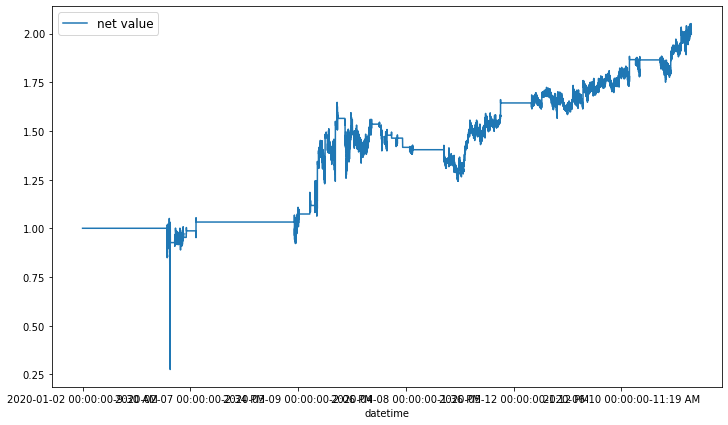

In [34]:
df2['net_value'].plot(figsize= (12, 7), label= 'net value')
plt.legend(fontsize= 12)

In [35]:
def evaluation(df):
    
    #年化收益率
    arp = (df['net_value'][-1] / df['net_value'][0] - 1)*2
    print('年化收益率: ', arp)
    
    #年化波动率
    df['r']= df['net_value'].pct_change(1)
    astd = df['r'].std() * np.sqrt(250)
    print('年化波动率: ', astd)
    
    #最大回撤
    index_j = np.argmax(np.maximum.accumulate(df['net_value']) - df['net_value']) #最大回撤结束位置
    index_i = np.argmax(df['net_value'][:index_j])  # 最大回撤开始位置
    max_call_back = 1 - df['net_value'][index_i] / df['net_value'][index_j]
    print('最大回撤: ', max_call_back)
    
    #胜率
    win_rate = (df['net_value'].diff()>0).sum() /  (df['net_value'].diff() != 0).sum()
    print('胜率: ', win_rate)

    #夏普
    Sharpe_ratio = arp/ astd
    print('夏普: ', Sharpe_ratio)

In [36]:
evaluation(df2)

年化收益率:  1.9910994466001304
年化波动率:  0.28311346567174644
最大回撤:  -2.8221539778785023
胜率:  0.4941850220264317
夏普:  7.032867341282502
